<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/VidasaExtended_Conv3DLSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install keras-layer-normalization
!pip install imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time

from IPython import display

from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2DTranspose, Conv3DTranspose, ConvLSTM2D, BatchNormalization, LayerNormalization, TimeDistributed, Conv2D, Conv3D, MaxPool3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

import matplotlib.pyplot as plt
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow


tf.keras.backend.set_floatx('float32')


TensorFlow 2.x selected.


In [0]:
class Config:
    def __init__(self, data_dir):
        self.DATASET_PATH = join(data_dir,"UCSDped2/Train")
        self.TEST_DIR = join(data_dir,"UCSDped2/Test/")
        self.BATCH_SIZE = 4
        self.EPOCHS = 10
        self.MODEL_PATH = join(data_dir,"model_conv3d_lstm_v2.hdf5")
        self.dim1 = 10
        self.dim2 = 16
        self.dim3 = 256
        self.dim4 = 256
        self.dim5 = 1

conf = Config(data_dir="/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/") 
physical_devices = tf.config.list_physical_devices('GPU') 
try: 
  tf.config.experimental.set_memory_growth(physical_devices[0], True) 
except: 
  # Invalid device or cannot modify virtual devices once initialized. 
  pass

In [5]:
def get_model(reload_model=True):
    """
        input dims = (10,16,256,256,1)
    """
    if reload_model == True and os.path.isfile(conf.MODEL_PATH):
        model=load_model(conf.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
        return model, True
    print("Loading model")
    seq = Sequential()
    seq.add(Conv3D(128, (3, 11, 11), strides=(1,4,4), padding="same", input_shape=(conf.dim2, conf.dim3, conf.dim4, conf.dim5)))
    seq.add(LayerNormalization())
    seq.add(Conv3D(64, (3, 5, 5), strides=(1,2,2), padding="same"))
    seq.add(LayerNormalization())
    seq.add(Conv3D(32, (3, 3, 3), strides=(1,2,2), padding="same"))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(Conv3DTranspose(32, (3, 3, 3), strides=(1,2,2), padding="same"))
    seq.add(LayerNormalization())
    seq.add(Conv3DTranspose(64, (3, 5, 5), strides=(1,2,2), padding="same"))
    seq.add(LayerNormalization())
    seq.add(Conv3DTranspose(128, (3, 11, 11), strides=(1,4,4), padding="same"))
    seq.add(LayerNormalization())
    seq.add(Conv3D(1, (3, 11, 11), activation="sigmoid", padding="same"))
    print(seq.summary(line_length=150))
    return seq, False

def train_v1():
    seq, loaded = get_model()
    if loaded == True:
        return seq

    training_set = np.array(get_clips_list(conf.dim2))
    #np_data.shape()

    #dataset = tf.data.Dataset.from_tensor_slices(np_data).batch(conf.BATCH_SIZE)

    seq.compile(loss='mse', optimizer=tf.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    !mkdir training_1
    checkpoint_path = "training_1/cp.ckpt"
    checkpoint_dir = dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

    seq.fit(training_set, training_set,
            batch_size=conf.BATCH_SIZE, epochs=conf.EPOCHS, shuffle=False, callbacks=[cp_callback])
    seq.save(conf.MODEL_PATH,save_format='h5')
    return seq


def get_loss(true_clips, pred_clips):
    return tf.keras.losses.MSE(y_true=true_clips, y_pred=pred_clips)

def get_optimizer():
    return tf.optimizers.Adam(1e-4, decay=1e-5, epsilon=1e-6)

@tf.function
def train_step(clips, model, optimizer):    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        reconstructed_clips = model(clips, training=True)
        reconstruction_loss = get_loss(reconstructed_clips, clips)

    gradients_of_model = gen_tape.gradient(reconstruction_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_model, model.trainable_variables))
   
def train():
    model, loaded = get_model()
    if loaded == True:
        return model
    np_data = np.array(get_training_set(conf.dim1))
    #np_data.shape()

    dataset = tf.data.Dataset.from_tensor_slices(np_data).batch(conf.BATCH_SIZE)
    optimizer = get_optimizer()
    for epoch in range(conf.EPOCHS):
        start = time.time()
    
        for clips_batch in dataset:
            train_step(clips_batch, model, optimizer)

        display.clear_output(wait=True)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    model.save(conf.MODEL_PATH,save_format='h5')
  
    display.clear_output(wait=True)


get_model()


Loading model
Model: "sequential"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
conv3d (Conv3D)                                                    (None, 16, 64, 64, 128)                                     46592                  
______________________________________________________________________________________________________________________________________________________
layer_normalization (LayerNormalization)                           (None, 16, 64, 64, 128)                                     256                    
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                           

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7fd47956b518>,
 False)

In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 32 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_clips_list(seq_size):
    """
    seq_size :int 
        The sequence size of individual clip
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 32-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size))
    return clips

def get_training_set(clip_seq_size):
    """
    clip_seq_size : int
        size of a single clips group
    Returns
    -------
    list
        creates list of lists of frames 
    """
    #print("test0")
    clips_array = []
    clips = get_clips_list(conf.dim2)
    #print(clips[0])
    tmp_clip = []
    count = 0
    for clip in clips:
        tmp_clip.append(clip)
        count = count +1
        if count == clip_seq_size:
            clips_array.append(tmp_clip)
            tmp_clip = []
            count = 0
    return clips_array

In [0]:
def get_single_test(single_test_path):
    sz = 200
    test = np.zeros(shape=(sz, conf.dim3, conf.dim4, conf.dim5))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((conf.dim3, conf.dim4))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


In [0]:
def evaluate(test_case_dir, model):

    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print("Test case loaded")
    sz = test.shape[0] - conf.dim2
    sequences = np.zeros((sz, conf.dim2, conf.dim3, conf.dim4, conf.dim5))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim2, conf.dim3, conf.dim4, conf.dim5))
        for j in range(0, conf.dim2):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    #sz_10x = sequences.shape[0] - conf.dim1
    #sequences_10x = np.zeros((sz_10x, conf.dim1, conf.dim2, conf.dim3, conf.dim4, conf.dim5))
    #count = 0
    #for k in range(0, sz_10x):
    #    clip_10x = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4, conf.dim5))
    #    for l in range(0, conf.dim1):
    #        clip_10x[l] = sequences[k + l, :, :, :, :] 
    #    sequences_10x[k] = clip_10x

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)

    #reconstruction shape = (sz_10x, 10, 16, 256, 256, 1)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    #print(sr.shape())
    
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()
    #sr = sigmoid(sr)
    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

Model Loaded
Test case loaded


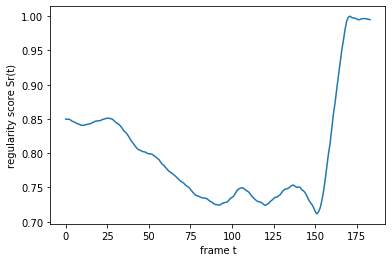

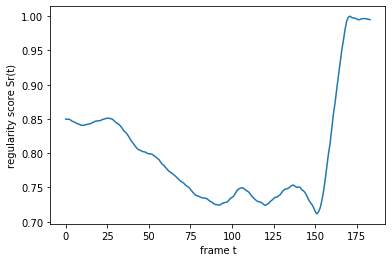

In [10]:


model = train_v1()
print("Model Loaded")
evaluate("Test004", model)